In [1]:
# conda env: tf

# try the ansatz that everyone else uses?

Damour, Nagar: https://arxiv.org/abs/1406.0401

Estelles+: https://arxiv.org/abs/2004.08302

Estelles+: https://arxiv.org/abs/2012.11923

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close();
plt.rcParams.update({'font.size':16, 'figure.figsize':(12,8)})

<Figure size 432x288 with 0 Axes>

# waveforms

In [3]:
!ls /Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022

metadata.csv strains.npy  times.npy


In [4]:

import numpy as np
import pandas as pd
import os

from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

In [5]:
import pandas as pd
import lmfit.models

In [6]:
datadir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [7]:
metadata = pd.read_csv(os.path.join(datadir, 'metadata.csv'))
strains = np.load(os.path.join(datadir, 'strains.npy'))
times = np.load(os.path.join(datadir, 'times.npy'))

In [8]:
strains.shape

(55, 8620)

In [9]:
metadata.query('q==1')

name    q     fring     fdamp  duration  t_final
18   SXS_BBH_0180_Res3  1.0  0.088087  0.013596    9359.5    236.6
20   SXS_BBH_0180_Res2  1.0  0.088087  0.013596    9354.6    236.8
22   SXS_BBH_0180_Res4  1.0  0.088087  0.013596    9270.5    236.4
27  RIT-eBBH-1090-n100  1.0  0.088087  0.013596    1493.9    362.0
31   RIT-BBH-0112-n100  1.0  0.088087  0.013596   16963.4    419.5

In [10]:
metadata.query('q==18')

name     q     fring    fdamp  duration  t_final
0  q18a0a0c025_96_fine  18.0  0.063334  0.01414    1020.0    465.8
6      q18a0a0c025_144  18.0  0.063334  0.01414    1028.3     88.8
8      q18a0a0c025_120  18.0  0.063334  0.01414    1027.5    174.7

In [11]:
idx = 0
# idx = 18
# idx = 22
# idx = 27
# idx = 54
# idx = 33
# idx = 34
metadata.loc[[idx]]

name     q     fring    fdamp  duration  t_final
0  q18a0a0c025_96_fine  18.0  0.063334  0.01414    1020.0    465.8

In [12]:
f_ring = metadata.loc[idx]['fring']
f_damp = metadata.loc[idx]['fdamp']

In [13]:
f_ring_angular = f_ring*2*np.pi
f_damp_angular = f_damp*2*np.pi

print(f_ring_angular)
print(f_damp_angular)

print(1/f_damp_angular)

0.3979406261371098
0.08884379830973939
11.25570967276369


In [14]:
strains[idx].shape

(8620,)

In [15]:
strain = strains[idx].copy()

# mask = (times > -50) & (times < 50)
# mask = (times > -100) & (times < 50)
# mask = (times > -100) & (times < 100)
# mask = (times > -100) & (times < 100)
mask = (times > -400) & (times < 100)
# mask = (times > -800) & (times < 100)
t = times[mask]
strain = strain[mask]
amp = np.abs(strain)
phi = np.unwrap(np.angle(strain))

In [16]:
times

array([-775. , -774.9, -774.8, ...,   86.7,   86.8,   86.9])

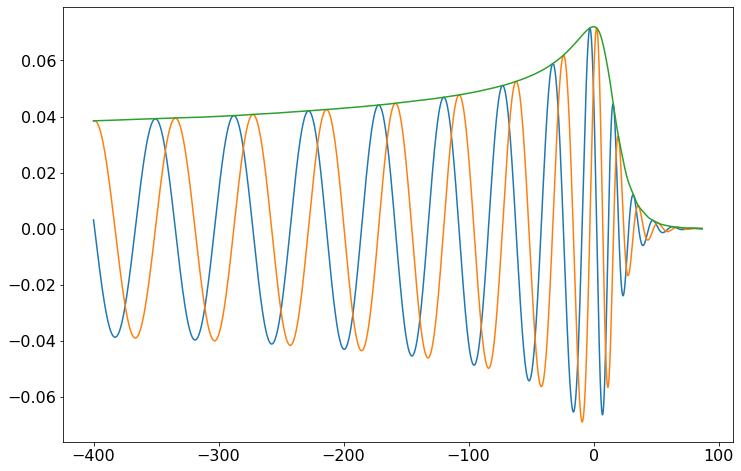

In [17]:
plt.plot(t, strain.real)
plt.plot(t, strain.imag)
plt.plot(t, amp)

In [18]:
mask_fit = (t >= 30) & (t <= 200)
x = t[mask_fit]
y_strain = strain[mask_fit]
y = y_strain.real

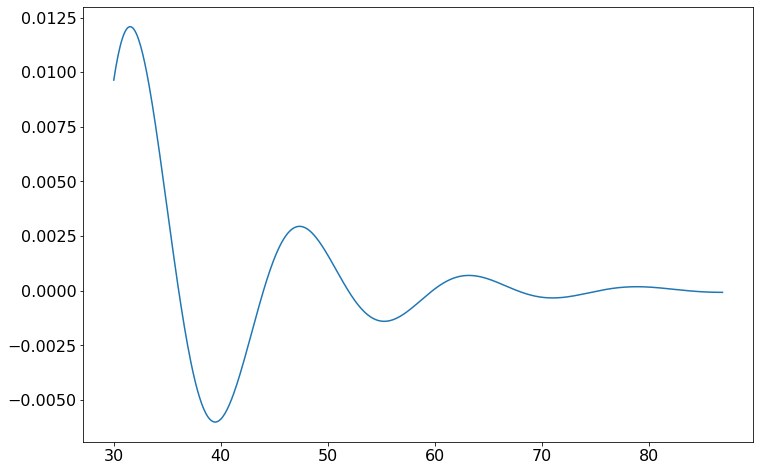

In [19]:
plt.plot(x, y)

In [20]:
def resid(params, x, ydata=None, use_sin=False):
    decay = params['decay'].value
    phi0 = params['phi0'].value
    t0 = params['t0'].value
    omega = params['omega'].value
    amp = params['amp'].value

    if use_sin:
        y_model = amp * np.exp(-(x-t0)/decay) * np.sin(x*omega + phi0)
    else:
        y_model = amp * np.exp(-(x-t0)/decay) * np.cos(x*omega + phi0)
    if type(ydata) == np.ndarray:
        return y_model - ydata
    else:
        return y_model

In [21]:


phi0_init = 1.0
t0_init = 1.0
amp_init = 0.5
# omega_init = 0.5
omega_init = f_ring_angular
# decay_init = 17
decay_init = 1/f_damp_angular


np.random.seed(2)
# x = np.linspace(0, 10, 101)
# y = offset + amp*np.sin(omega*x) * np.exp(-x/decay)
# yn = y + np.random.normal(size=y.size, scale=0.450)

params = lmfit.Parameters()
params.add('phi0', phi0_init, min=-100, max=100.0)
params.add('t0', t0_init, min=-100, max=100.0)
params.add('omega', omega_init, min=0, max=100.0, vary=False)
params.add('amp', amp_init, min=0, max=100.0)
params.add('decay', decay_init, min=0, max=100.0, vary=False)
# params.add('decay', 11, min=0, max=100.0, vary=False)
o1 = lmfit.minimize(resid, params, args=(x, y), method='leastsq')
print("# Fit using leastsq:")
lmfit.report_fit(o1)

# Fit using leastsq:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 570
    # variables        = 3
    chi-square         = 7.3995e-07
    reduced chi-square = 1.3050e-09
    Akaike info crit   = -11657.5210
    Bayesian info crit = -11644.4841
##  Warning: uncertainties could not be estimated:
[[Variables]]
    phi0:  -6.49759539 +/- 5.3515e-04 (0.01%) (init = 1)
    t0:    -55.5174593 +/-        nan (nan%) (init = 1)
    omega:  0.3979406 (fixed)
    amp:    28.3532409 +/-        nan (nan%) (init = 0.5)
    decay:  11.25571 (fixed)


In [22]:
o1.params

Parameters([('phi0', <Parameter 'phi0', value=-6.497595391599958 +/- 0.000535, bounds=[-100:100.0]>), ('t0', <Parameter 't0', value=-55.51745928287244 +/- nan, bounds=[-100:100.0]>), ('omega', <Parameter 'omega', value=0.3979406261371098 (fixed), bounds=[0:100.0]>), ('amp', <Parameter 'amp', value=28.353240854079985 +/- nan, bounds=[0:100.0]>), ('decay', <Parameter 'decay', value=11.25570967276369 (fixed), bounds=[0:100.0]>)])

In [23]:
yhat = resid(o1.params, x)

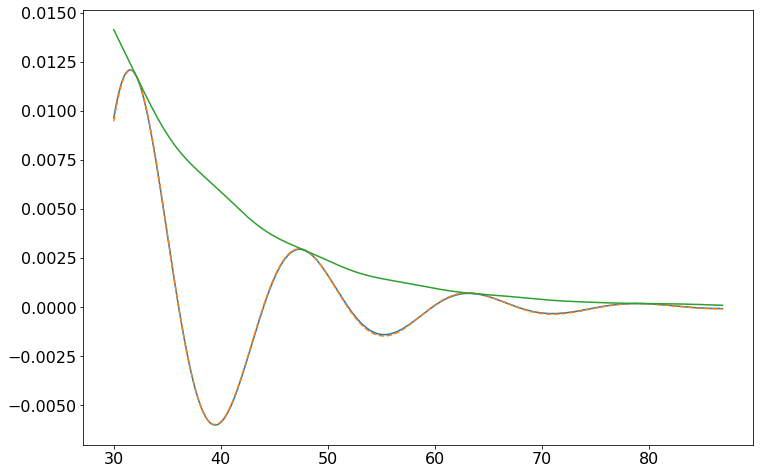

In [24]:
plt.figure()
plt.plot(x, y)
plt.plot(x, yhat, ls='--')
plt.plot(x, np.abs(y_strain))
# plt.yscale('log')

In [25]:
# evaluate ringdown fit at times from t=0

In [91]:
# mask = (t >= -1000) & (t <= 200)
# mask = (t >= -100) & (t <= 200)
mask = (t >= 0) & (t <= 200)
x = t[mask]
y = strain[mask]

In [92]:
yhat_real = resid(o1.params, x)

In [93]:
yhat_imag = resid(o1.params, x, use_sin=True)

In [94]:
yhat = yhat_real + 1.j*yhat_imag

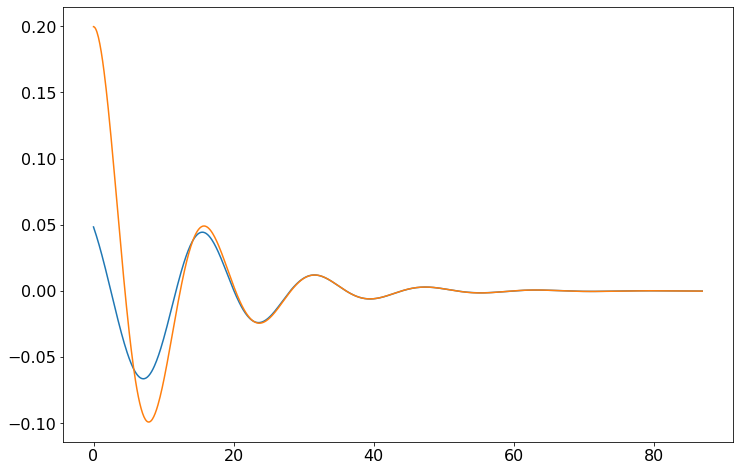

In [95]:
plt.plot(x, y.real)
plt.plot(x, yhat.real)

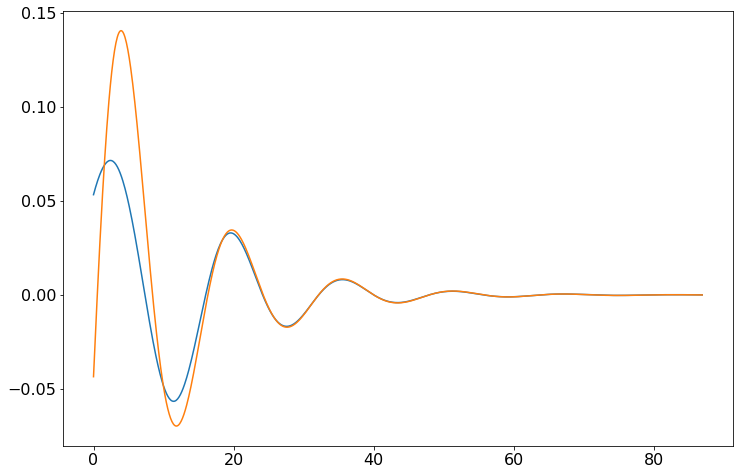

In [96]:
plt.plot(x, y.imag)
plt.plot(x, yhat.imag)

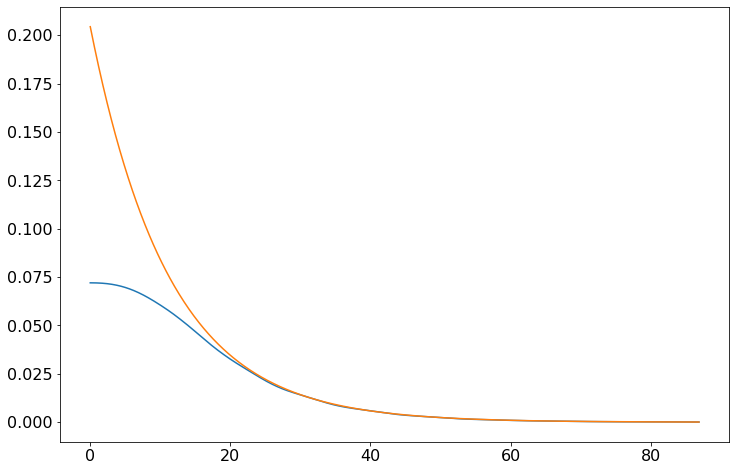

In [97]:
plt.plot(x, np.abs(y))
plt.plot(x, np.abs(yhat))

In [98]:
# not this - it's a multiplicative decomposition of complex numbers
ybar = y-yhat
ybar_phase = np.unwrap(np.angle(ybar))

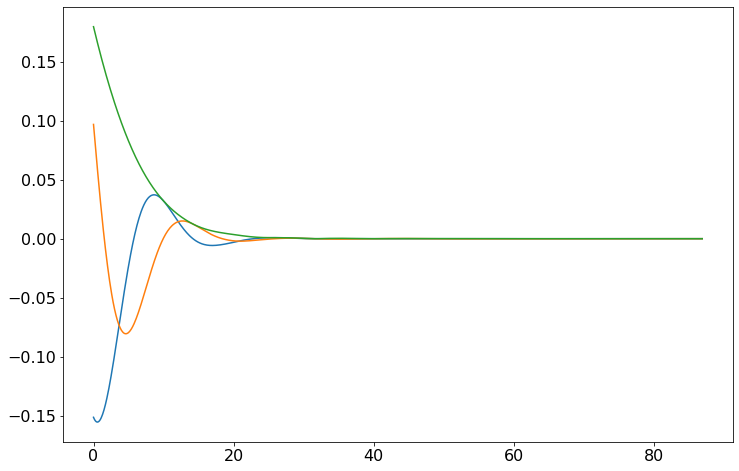

In [99]:
plt.plot(x, ybar.real)
plt.plot(x, ybar.imag)
plt.plot(x, np.abs(ybar))

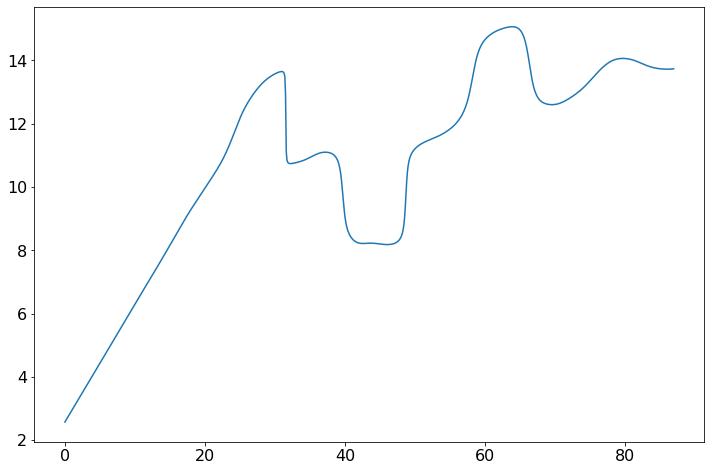

In [100]:
plt.plot(x, ybar_phase)

In [101]:
# eq.1 from https://arxiv.org/abs/1406.0401
# like this
ybar = y*np.conj(yhat)
ybar_phase = np.unwrap(np.angle(ybar))

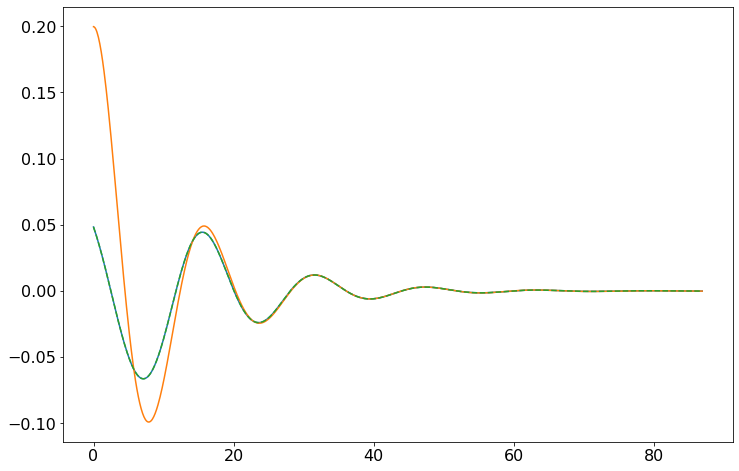

In [116]:
plt.plot(x, y.real)
plt.plot(x, yhat.real)
plt.plot(x, np.real(ybar/np.conj(yhat)), ls='--')

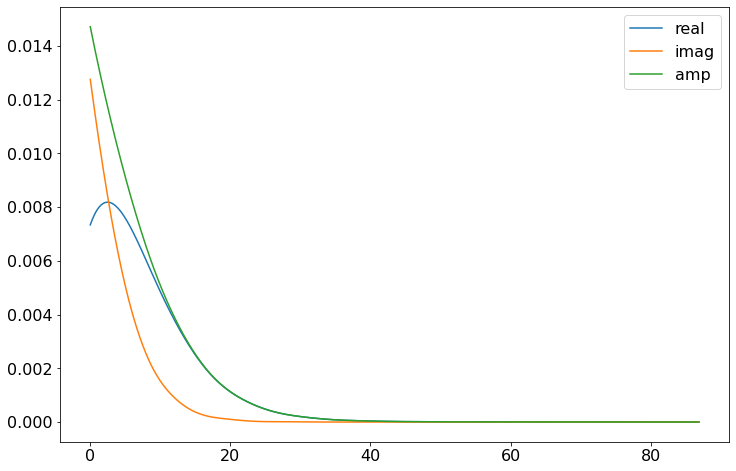

In [103]:
plt.plot(x, ybar.real, label='real')
plt.plot(x, ybar.imag, label='imag')
plt.plot(x, np.abs(ybar), label='amp')
plt.legend()

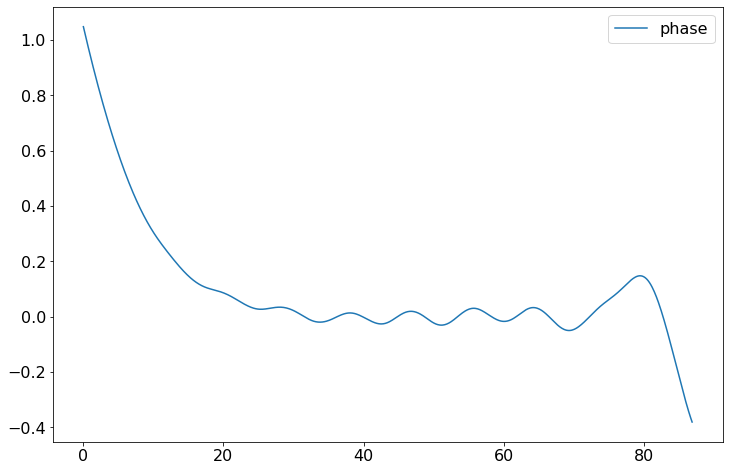

In [104]:
plt.plot(x, ybar_phase, label='phase')
plt.legend()

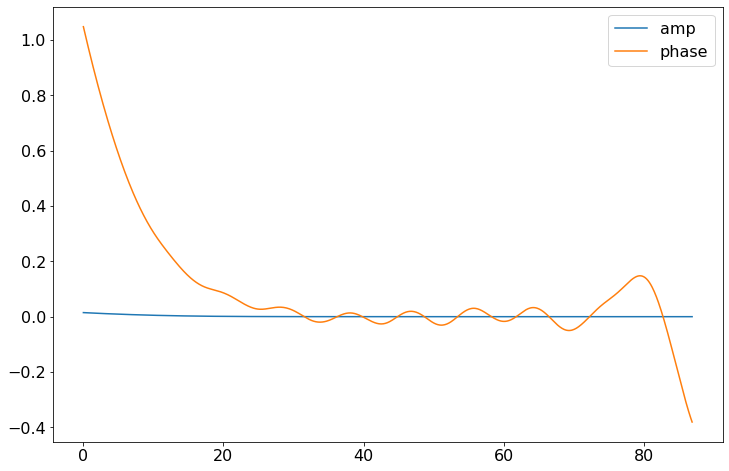

In [105]:
plt.plot(x, np.abs(ybar), label='amp')
plt.plot(x, ybar_phase, label='phase')
plt.legend()

In [106]:
# look at log scale

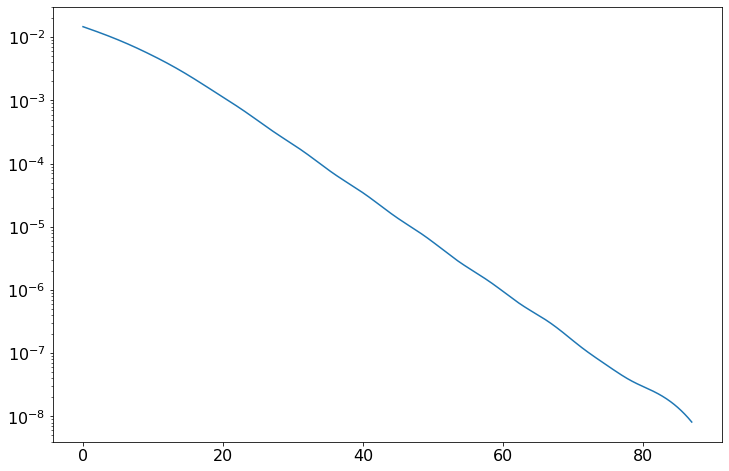

In [113]:
plt.plot(x, np.abs(ybar))
plt.yscale('log')

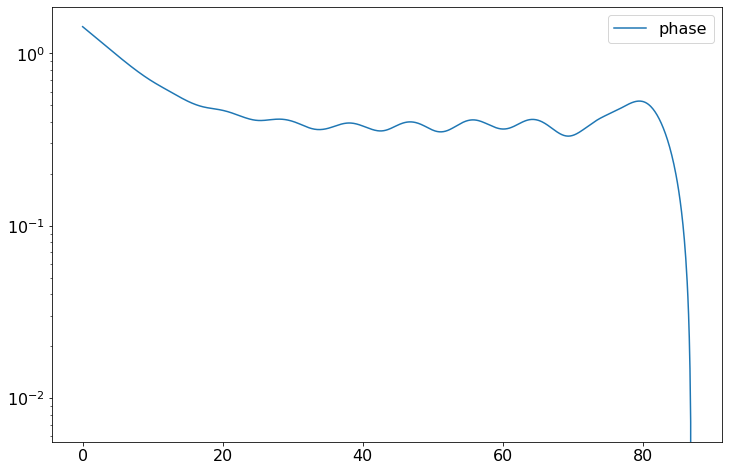

In [115]:
plt.plot(x, ybar_phase-ybar_phase[-1], label='phase')
plt.legend()
plt.yscale('log')

In [109]:
ybar_amp_d1 = IUS(x, np.abs(ybar)/np.abs(ybar)[0]).derivative()(x)
ybar_phase_d1 = IUS(x, ybar_phase).derivative(n=1)(x)


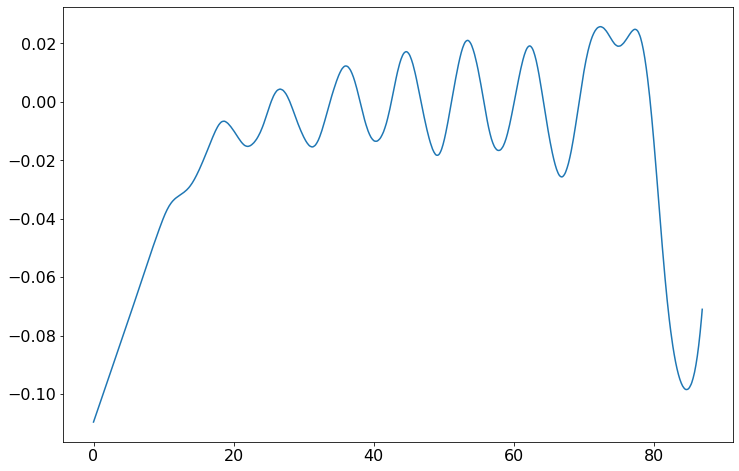

In [111]:
# plt.plot(x-x[0]+1e-3, -ybar_amp_d1+1e-9)
plt.plot(x, ybar_phase_d1)
# plt.yscale('log')
# plt.xscale('log')

# co-rotating frame

this stuff is basically a co-rotating frame that is co-rotating with the perturbation?

let's do it for the inspiral waveform

In [138]:
# mask = (t >= -1000) & (t <= 200)
mask = (t >= -100) & (t <= 200)
x = t[mask]
y = strain[mask]

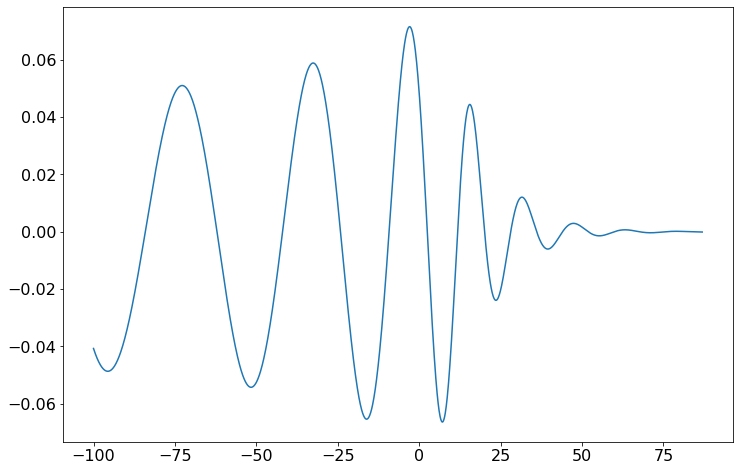

In [139]:
plt.plot(x, y.real)

In [140]:
# compute orbital phase

In [141]:
phi_22 = np.unwrap(np.angle(y))
phi_orb = phi_22/2

In [142]:
amp_22 = np.abs(y)

In [143]:
h_orb = amp_22 * np.exp(-1.j*phi_orb)

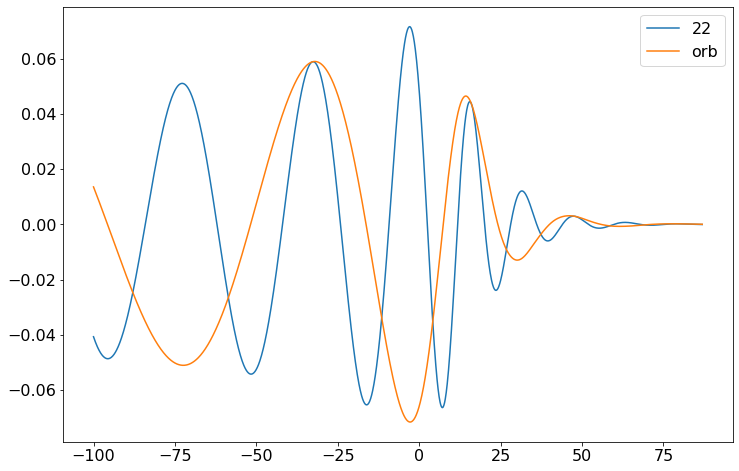

In [144]:
plt.plot(x, y.real, label='22')
plt.plot(x, h_orb.real, label='orb')
plt.legend()

In [145]:
# here it's not interesting because I have the full complete waveform so
# we are just left with the real part as the imaginary part is now zero

# but it's a nice way to build up higher multipoles from just the 22 multipole.

# i.e. assume h_lm = fac * h_22
# and then model deviations from this relationship

In [146]:
h_co_orb = y * np.conj(y)

In [147]:
h_co_orb[:10]

array([0.00233279+0.j, 0.00233357+0.j, 0.00233435+0.j, 0.00233513+0.j,
       0.00233591+0.j, 0.00233669+0.j, 0.00233747+0.j, 0.00233826+0.j,
       0.00233904+0.j, 0.00233982+0.j])

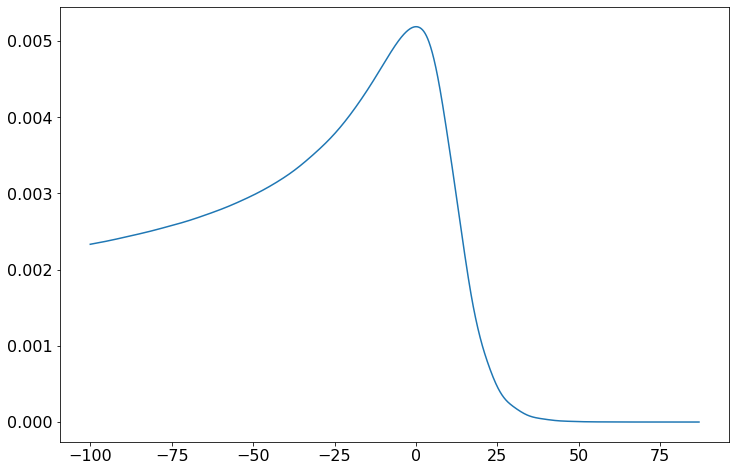

In [150]:
plt.plot(x, np.real(h_co_orb))